In [51]:
#Imports
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import glob
import random
import PIL
from PIL import Image


AUTOTUNE = tf.data.experimental.AUTOTUNE

#Variables
batch_size = 10
buffer_size = 1000
image_size = 64


def parse_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask_path = tf.strings.regex_replace(img_path, "ISIC2018_Task1-2_Training_Input_x2", "ISIC2018_Task1_Training_GroundTruth_x2")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", "_segmentation.png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 1)
    return {'image': image, 'seg_mask': mask}

def load_image_train(datapoint: dict):
    input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
    input_mask = tf.image.resize(datapoint['seg_mask'], (image_size, image_size))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

def load_image_test(datapoint: dict):
    input_image = tf.image.resize(datapoint['image'], (image_size, image_size))
    input_mask = tf.image.resize(datapoint['seg_mask'], (image_size, image_size))
    
    input_image, image_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask
    
def display_sample(image_list):
    plt.figure(figsize = (16,16))

    for i in range(len(image_list)):
        plt.subplot(1,len(image_list), i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]), cmap = "RdGy")
        plt.axis('off')
    plt.show()

@tf.function
def normalize (input_image, input_mask):
    
    #input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask









2078
259
258


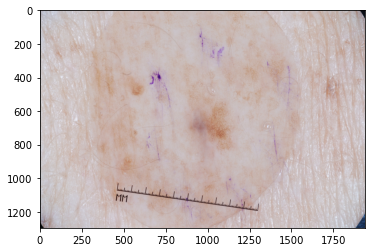

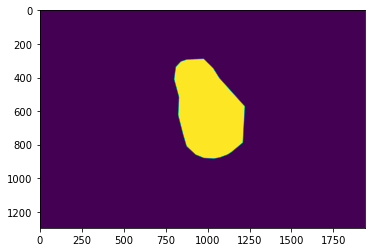

In [45]:
dataset_path = "D:/Drive D/Data Science/Semester 4/COMP3710/ISIC/ISIC2018_Task1-2_Training_Input_x2/*"

files = glob.glob(dataset_path)
random.shuffle(files)

train_data, validate_data, test_data = files[:2078], files[2078:2337], files[2337:2596]

train_seg, validate_seg, test_seg = train_data, validate_data, test_data


print(len(train_data))
print(len(validate_data))
print(len(test_data))

img = parse_image(train_data[0])

#print(img['image'])

plt.imshow(tf.keras.preprocessing.image.array_to_img(img['image']))
plt.show()
plt.imshow(tf.keras.preprocessing.image.array_to_img(img['seg_mask']))
plt.show()

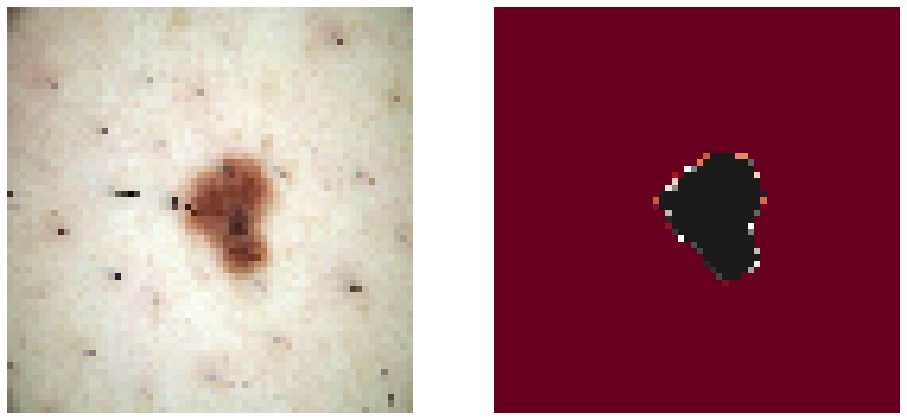

In [52]:
seed = 42
train_set = tf.data.Dataset.list_files(train_data, seed = seed)
train_set = train_set.map(parse_image)
test_set = tf.data.Dataset.list_files(test_data, seed = seed)
test_set = test_set.map(parse_image)
val_set = tf.data.Dataset.list_files(validate_data, seed = seed)
val_set = val_set.map(parse_image)

dataset = {"train": train_set, "val": val_set}

dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size = buffer_size, seed = seed)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(batch_size)
dataset['train'] = dataset['train'].prefetch(buffer_size = AUTOTUNE)

dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(batch_size)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    
display_sample([sample_image[0], sample_mask[0]])   


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

input_size = (image_size, image_size, 3)
ini = "he_nomral"

###Pseudocode for YOLO

#Conv Layer - 7x7x64-s-2
#MaxPool Layer - 2x2-s-2

#Conv Layer - 3x3x192
#Maxpool Layer - 2x2-s-2

#Conv Layer - 1x1x128
#Conv Layer - 3x3x256
#Conv Layer - 1x1x256
#Conv Layer - 3x3x512
#MaxPool Layer - 2x2-s-2

#Conv Layer - 1x1x256
#Conv Layer - 3x3x512
#Conv Layer - 1x1x256
#Conv Layer - 3x3x512
#Conv Layer - 1x1x256
#Conv Layer - 3x3x512
#Conv Layer - 1x1x256
#Conv Layer - 3x3x512
#Conv Layer - 1x1x512
#Conv Layer - 3x3x1024
#MaxPool Layer - 2x2-s-2

#Conv Layer - 1x1x512
#Conv Layer - 3x3x512
#Conv Layer - 1x1x512
#Conv Layer - 3x3x512
#Conv Layer - 3x3x1024
#Conv Layer - 3x3x1024-s-2

#Conv Layer - 3x3x1024
#Conv Layer - 3x3x1024

#Flatten
#Dense layer - 512
#Dense Layer - 1024
#Dense - 1470 - "sigmoid"
#Reshape - 7x7x30

#






